<a href="https://colab.research.google.com/github/abidamer95/compvision/blob/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets

Download Oxford102 flowers train dataset

In [ ]:
train_dataset = datasets.Flowers102(root='./data', split='train', download=True)

100%|██████████| 345M/345M [00:17<00:00, 20.2MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.54MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 35.9MB/s]


Iterate through the dataset to collect the width, height, and color channel data for each image.

In [ ]:
stats = []

for img, label in tqdm(train_dataset, desc="Processing Images"):
    w, h = img.size
    # Convert image to RGB to ensure 3 channels for distribution analysis
    img_rgb = img.convert('RGB')

    stats.append({
        'width': w,
        'height': h,
        'aspect_ratio': w / h,
        'label': label
    })

df = pd.DataFrame(stats)

Processing Images: 100%|██████████| 1020/1020 [00:03<00:00, 277.76it/s]


Create histogram using Matplotlib
*   Most of the images in dataset are in landscape orientation
*   Variation in image size may affect model training

Resizing the image is required before loading the dataset into dataloader



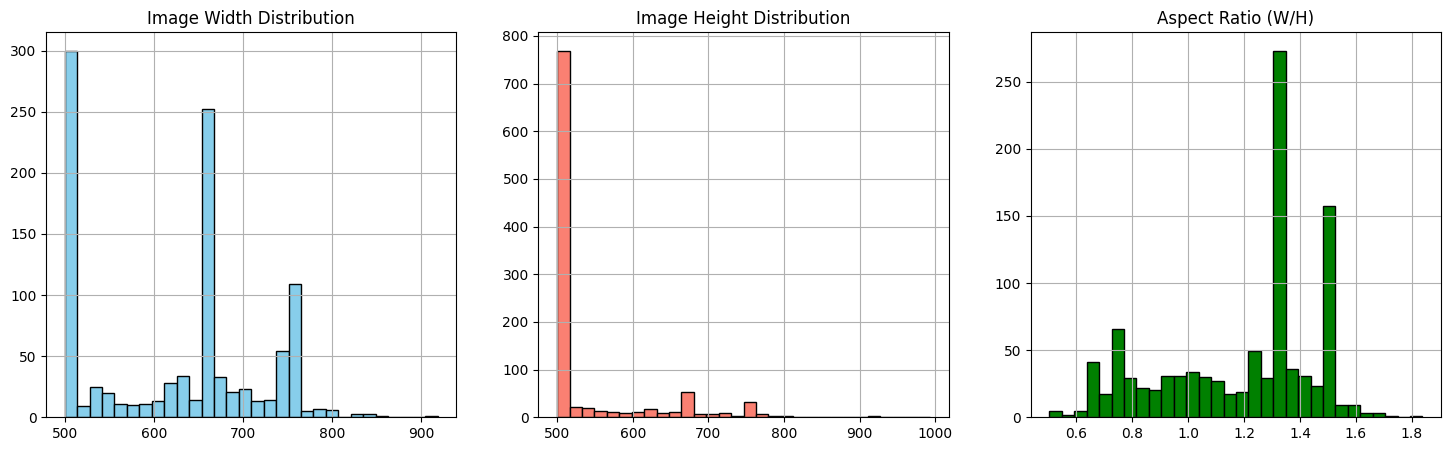

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width Distribution
df['width'].hist(ax=axes[0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Image Width Distribution')

# Height Distribution
df['height'].hist(ax=axes[1], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('Image Height Distribution')

# Aspect Ratio Distribution
df['aspect_ratio'].hist(ax=axes[2], bins=30, color='green', edgecolor='black')
axes[2].set_title('Aspect Ratio (W/H)')

plt.show()

Analyze colour channel intensities
*   The image reside mostly in the green and red part of the RGB spectrum
*   Most image consist of bright flower petals with green leaves background which support the analysis



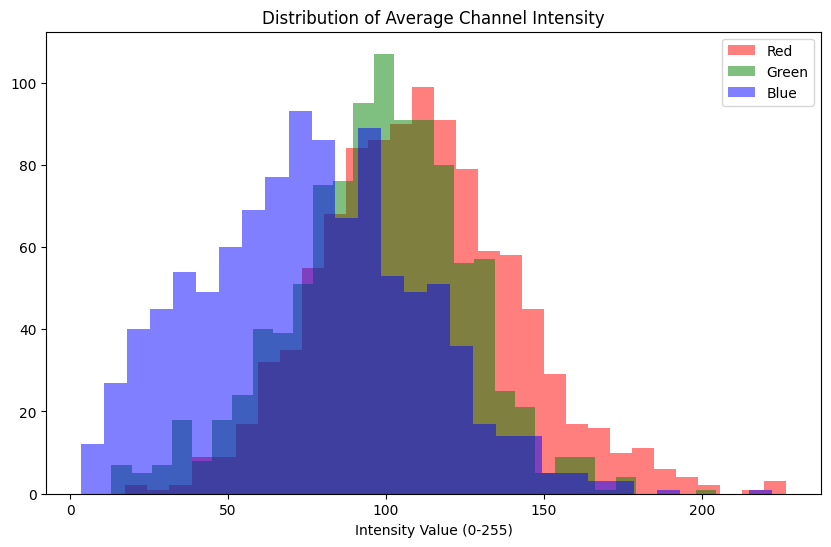

In [ ]:
red_means, green_means, blue_means = [], [], []

for img, _ in train_dataset:
    img_array = np.array(img.convert('RGB'))
    red_means.append(np.mean(img_array[:, :, 0]))
    green_means.append(np.mean(img_array[:, :, 1]))
    blue_means.append(np.mean(img_array[:, :, 2]))

plt.figure(figsize=(10, 6))
plt.hist(red_means, bins=30, alpha=0.5, label='Red', color='red')
plt.hist(green_means, bins=30, alpha=0.5, label='Green', color='green')
plt.hist(blue_means, bins=30, alpha=0.5, label='Blue', color='blue')
plt.title('Distribution of Average Channel Intensity')
plt.xlabel('Intensity Value (0-255)')
plt.legend()
plt.show()


Visualize Class Distribution
*   The class distribution in this test dataset is not consistent where some of the class can have up to 50 images
*   Some of the class with few images require image augmentation





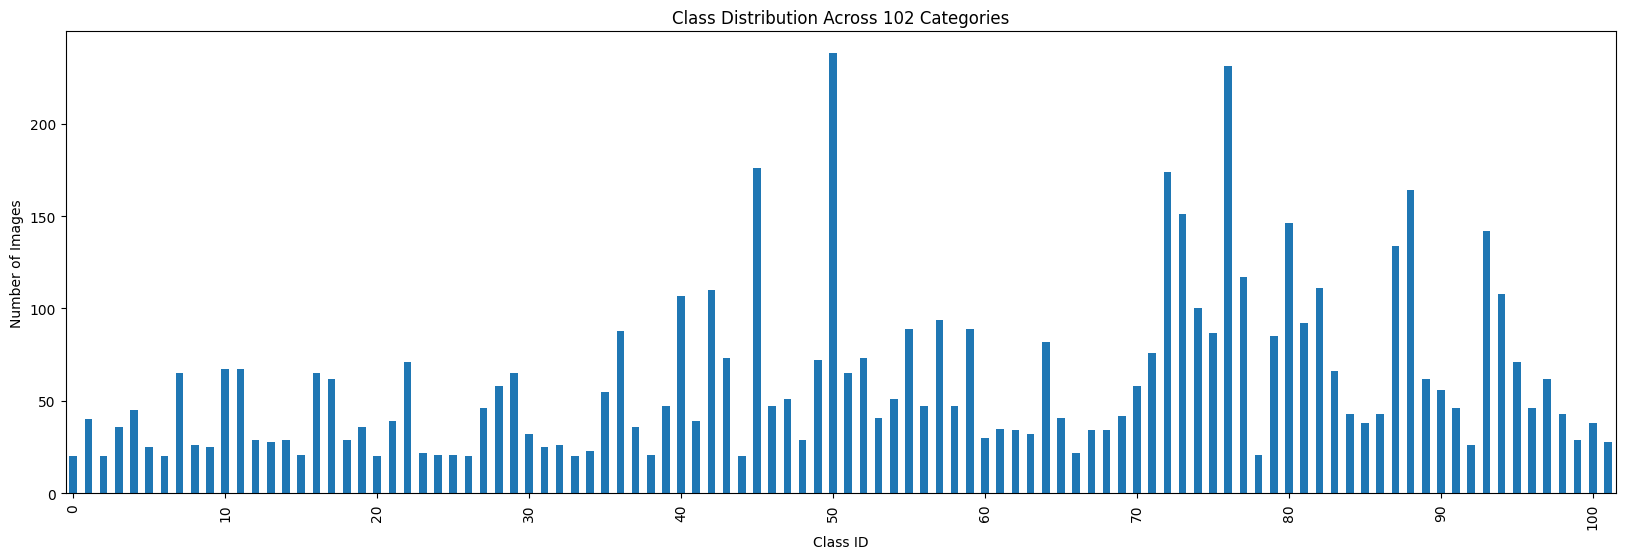

In [ ]:
#Load 'test' split to visualize the class sizes distribution.
test_dataset = datasets.Flowers102(root='./data', split='test', download=True)

# Collect all labels
labels = [label for _, label in test_dataset]
label_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(20, 6))
label_counts.plot(kind='bar')
plt.title('Class Distribution Across 102 Categories')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(np.arange(0, 102, 10)) # Show every 10th label
plt.show()

In [ ]:
#get top 10 classes with the most images
top_10 = pd.Series(labels).value_counts().head(10)

print("Top 10 labels by image count:")
print(top_10)

Top 10 labels by image count:
50    238
76    231
45    176
72    174
88    164
73    151
80    146
93    142
87    134
77    117
Name: count, dtype: int64


Images augmentation using random flip function and data loader using PyTorch

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2

train_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.2),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transforms = v2.Compose([
    v2.Resize(size=(224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Load Datasets
train_data = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
val_data = datasets.Flowers102(root='./data', split='val', download=True, transform=test_transforms)
test_data = datasets.Flowers102(root='./data', split='test', download=True, transform=test_transforms)

# 3. Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

Display loaded image

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


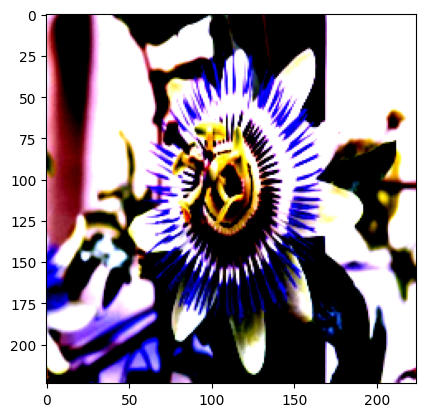

Label: 76


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")